# Problem Set: Improving GANs for Airfoil Generation

## Learning Objectives

In this problem set, you will:
1. Train a baseline GAN on 1D airfoil curves
2. Diagnose training issues using metrics and visualizations
3. Select and implement GAN improvements from a "word bank" of modern techniques
4. Hypothesize the impact of each improvement before testing
5. Compare results and understand which techniques help in which scenarios

## Overview

Generative Adversarial Networks are notoriously difficult to train. Over the years, researchers have developed various techniques to improve training stability, output quality, and diversity. In this exercise, you'll work with a 1D GAN that generates airfoil shapes.

You'll start with a **baseline implementation** that has known issues, then systematically apply improvements from the literature to see their effects.

---

## Problem Setup: Airfoil Generation

**Dataset:** 1,528 airfoil curves, each represented as 192 (x,y) coordinate pairs  
**Task:** Generate realistic airfoil shapes  
**Challenge:** Airfoils must be smooth, physically valid, and diverse

## Setup and Imports

In [ ]:
import os
import io
import numpy as np
import torch as th
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from typing import NamedTuple, Optional
import requests
from sklearn.decomposition import PCA
import warnings
import random
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100

# Set seeds for reproducibility
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
th.manual_seed(SEED)
th.cuda.manual_seed(SEED)
th.cuda.manual_seed_all(SEED)
th.backends.cudnn.deterministic = True
th.backends.cudnn.benchmark = False

# Device selection
if th.backends.mps.is_available():
    device = th.device("mps")
    # Set MPS seed
    th.mps.manual_seed(SEED)
elif th.cuda.is_available():
    device = th.device("cuda")
else:
    device = th.device("cpu")

print(f"Using device: {device}")
print(f"Random seed: {SEED}")

Using device: mps


## Load Airfoil Dataset

Dataset shape: (1528, 192, 2)
Number of airfoils: 1528
Points per airfoil: 192

Normalized data range: [-1.000, 1.000]


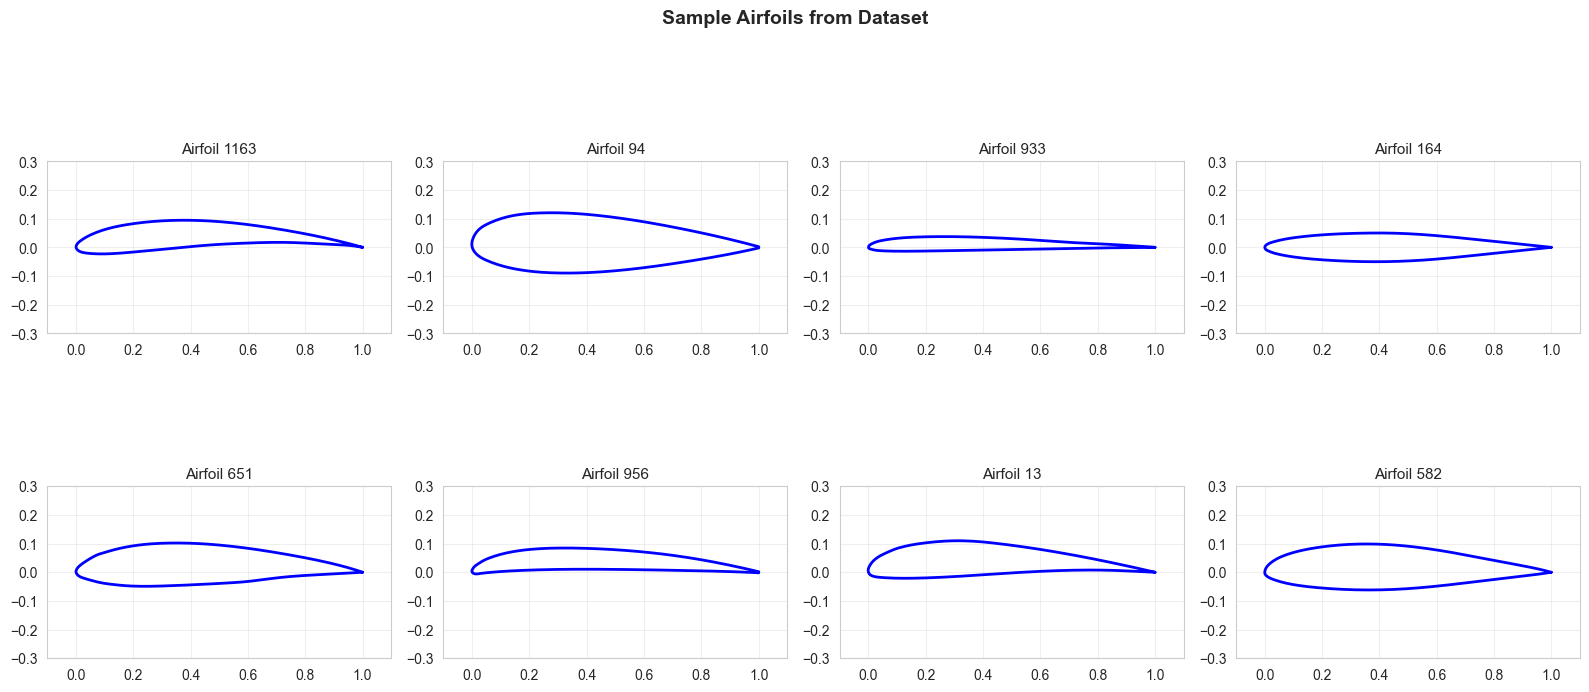

In [2]:
# Load airfoil data
url = "https://github.com/IDEALLab/ML4ME_Textbook/raw/main/part1/airfoil_interp_uniform.npy"
response = requests.get(url)
X_airfoils = np.load(io.BytesIO(response.content))  # Shape: (1528, 192, 2)

print(f"Dataset shape: {X_airfoils.shape}")
print(f"Number of airfoils: {X_airfoils.shape[0]}")
print(f"Points per airfoil: {X_airfoils.shape[1]}")

# Flatten to (N, 384) for easier handling
X_flat = X_airfoils.reshape(X_airfoils.shape[0], -1)

# Normalize to [-1, 1] range (important for tanh output)
X_mean = X_flat.mean(axis=0, keepdims=True)
X_std = X_flat.std(axis=0, keepdims=True) + 1e-8
X_normalized = (X_flat - X_mean) / X_std
X_normalized = np.clip(X_normalized, -3, 3) / 3  # Soft clip to [-1, 1]

print(f"\nNormalized data range: [{X_normalized.min():.3f}, {X_normalized.max():.3f}]")

# Visualize some airfoils
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()
for i in range(8):
    idx = np.random.randint(0, len(X_airfoils))
    airfoil = X_airfoils[idx]
    axes[i].plot(airfoil[:, 0], airfoil[:, 1], 'b-', linewidth=2)
    axes[i].set_aspect('equal')
    axes[i].set_title(f'Airfoil {idx}', fontsize=11)
    axes[i].grid(True, alpha=0.3)
    axes[i].set_xlim(-0.1, 1.1)
    axes[i].set_ylim(-0.3, 0.3)
plt.suptitle('Sample Airfoils from Dataset', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Convert to PyTorch Tensor

In [3]:
# Convert to PyTorch tensor
X_tensor = th.FloatTensor(X_normalized).to(device)

print(f"Tensor shape: {X_tensor.shape}")

Tensor shape: torch.Size([1528, 384])


In [4]:
class TrainingHistory(NamedTuple):
    """Store training metrics."""
    d_loss: list
    g_loss: list
    d_real_score: list
    d_fake_score: list
    diversity: list
    gradient_penalty: list  # For WGAN-GP
    

def compute_diversity(samples: th.Tensor) -> float:
    """Compute diversity using average pairwise L2 distance."""
    samples_flat = samples.reshape(samples.size(0), -1)
    dists = th.cdist(samples_flat, samples_flat, p=2)
    n = samples.size(0)
    if n <= 1:
        return 0.0
    # Average of upper triangular (exclude diagonal)
    return dists.sum().item() / (n * (n - 1))


def plot_pca_coverage(generator, latent_dim: int, title_suffix: str = "", n_samples: int = 500):
    """Plot 2D PCA visualization comparing real vs generated distribution."""
    generator.eval()
    
    # Generate samples
    with th.no_grad():
        z = th.randn(n_samples, latent_dim, device=device)
        gen_designs_flat = generator(z).cpu().numpy()
    
    # Denormalize generated samples
    gen_designs_flat = gen_designs_flat * 3 * X_std + X_mean
    
    # Get real samples (denormalized)
    real_designs_flat = X_flat
    
    # Fit PCA on real data
    pca = PCA(n_components=2)
    real_pca = pca.fit_transform(real_designs_flat)
    gen_pca = pca.transform(gen_designs_flat)
    
    # Plot
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    
    # Plot real data
    ax.scatter(real_pca[:, 0], real_pca[:, 1], alpha=0.3, s=20, c='blue', label='Real', edgecolors='none')
    
    # Plot generated data
    ax.scatter(gen_pca[:, 0], gen_pca[:, 1], alpha=0.5, s=20, c='red', label='Generated', edgecolors='none')
    
    ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=12)
    ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=12)
    ax.set_title(f'2D PCA: Real vs Generated Distribution{title_suffix}', fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


def plot_training_diagnostics(history: TrainingHistory, title_suffix: str = ""):
    """Plot comprehensive training diagnostics."""
    fig = plt.figure(figsize=(16, 10))
    gs = GridSpec(3, 3, figure=fig, hspace=0.3, wspace=0.3)
    
    epochs = np.arange(1, len(history.d_loss) + 1)
    
    # Row 1: Losses
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(epochs, history.d_loss, label='Discriminator', linewidth=2, alpha=0.8, color='C0')
    ax1.plot(epochs, history.g_loss, label='Generator', linewidth=2, alpha=0.8, color='C1')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training Losses', fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.plot(epochs, history.d_real_score, label='D(real)', linewidth=2, alpha=0.8, color='C2')
    ax2.plot(epochs, history.d_fake_score, label='D(fake)', linewidth=2, alpha=0.8, color='C3')
    ax2.axhline(y=0.5, color='k', linestyle='--', alpha=0.4, linewidth=1.5, label='Random')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Score')
    ax2.set_title('Discriminator Predictions', fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(-0.05, 1.05)
    
    ax3 = fig.add_subplot(gs[0, 2])
    loss_ratio = np.array(history.d_loss) / (np.array(history.g_loss) + 1e-8)
    ax3.plot(epochs, loss_ratio, linewidth=2, alpha=0.8, color='purple')
    ax3.axhline(y=1.0, color='k', linestyle='--', alpha=0.4, linewidth=1.5)
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('D_loss / G_loss')
    ax3.set_title('Loss Ratio (Balance Check)', fontweight='bold')
    ax3.grid(True, alpha=0.3)
    
    # Row 2: Diversity and gradient penalty
    ax4 = fig.add_subplot(gs[1, 0])
    ax4.plot(epochs, history.diversity, linewidth=2, alpha=0.8, color='teal')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Avg Pairwise Distance')
    ax4.set_title('Sample Diversity', fontweight='bold')
    ax4.grid(True, alpha=0.3)
    
    if any(gp > 0 for gp in history.gradient_penalty):
        ax5 = fig.add_subplot(gs[1, 1])
        ax5.plot(epochs, history.gradient_penalty, linewidth=2, alpha=0.8, color='orange')
        ax5.set_xlabel('Epoch')
        ax5.set_ylabel('Gradient Penalty')
        ax5.set_title('WGAN Gradient Penalty', fontweight='bold')
        ax5.grid(True, alpha=0.3)
    
    # Row 3: Score gap and loss smoothness
    ax6 = fig.add_subplot(gs[1, 2])
    score_gap = np.array(history.d_real_score) - np.array(history.d_fake_score)
    ax6.plot(epochs, score_gap, linewidth=2, alpha=0.8, color='darkgreen')
    ax6.axhline(y=0, color='k', linestyle='--', alpha=0.4, linewidth=1.5)
    ax6.set_xlabel('Epoch')
    ax6.set_ylabel('D(real) - D(fake)')
    ax6.set_title('Discriminator Score Gap', fontweight='bold')
    ax6.grid(True, alpha=0.3)
    
    plt.suptitle(f'Training Diagnostics{title_suffix}', fontsize=16, fontweight='bold')
    plt.show()


def plot_generated_airfoils(generator, latent_dim: int, 
                           title_suffix: str = "", n_samples: int = 8):
    """Visualize generated airfoils."""
    generator.eval()
    
    # Sample random airfoils from dataset for comparison
    indices = np.random.choice(len(X_airfoils), n_samples, replace=False)
    real_designs = X_airfoils[indices]
    
    # Generate airfoils
    with th.no_grad():
        z = th.randn(n_samples, latent_dim, device=device)
        gen_designs_flat = generator(z).cpu().numpy()
    
    # Denormalize
    gen_designs_flat = gen_designs_flat * 3 * X_std + X_mean
    gen_designs = gen_designs_flat.reshape(n_samples, 192, 2)
    
    # Plot
    fig, axes = plt.subplots(2, n_samples, figsize=(20, 6))
    
    for i in range(n_samples):
        # Real
        axes[0, i].plot(real_designs[i, :, 0], real_designs[i, :, 1], 'b-', linewidth=2)
        axes[0, i].set_aspect('equal')
        axes[0, i].set_xlim(-0.1, 1.1)
        axes[0, i].set_ylim(-0.3, 0.3)
        axes[0, i].grid(True, alpha=0.3)
        if i == 0:
            axes[0, i].set_ylabel('Real', fontsize=12, fontweight='bold')
        axes[0, i].set_xticks([])
        axes[0, i].set_yticks([])
        
        # Generated
        axes[1, i].plot(gen_designs[i, :, 0], gen_designs[i, :, 1], 'r-', linewidth=2)
        axes[1, i].set_aspect('equal')
        axes[1, i].set_xlim(-0.1, 1.1)
        axes[1, i].set_ylim(-0.3, 0.3)
        axes[1, i].grid(True, alpha=0.3)
        if i == 0:
            axes[1, i].set_ylabel('Generated', fontsize=12, fontweight='bold')
        axes[1, i].set_xticks([])
        axes[1, i].set_yticks([])
    
    plt.suptitle(f'Real vs Generated Airfoils{title_suffix}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

print("Training utilities defined.")

Training utilities defined.


---

# Part 1: Baseline GAN

We start with a **vanilla GAN** using:
- Binary Cross-Entropy (BCE) loss
- Standard fully-connected architectures
- Basic Adam optimizer
- **No batch normalization**
- **No dropout**
- **Moderate learning rates** (1e-4)

**Note:** The baseline is intentionally simplified to create a clean starting point. This helps you better appreciate the benefits of the improvement techniques you'll implement later.

## Baseline Architecture

In [ ]:
class BaselineGenerator(nn.Module):
    """Baseline unconditional generator for 1D airfoil curves."""
    
    def __init__(self, latent_dim: int, output_dim: int):
        super().__init__()
        
        def block(in_feat: int, out_feat: int):
            layers = [nn.Linear(in_feat, out_feat)]
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers
        
        # Main generation path
        self.model = nn.Sequential(
            *block(latent_dim, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, output_dim),
            nn.Tanh(),  # Output in [-1, 1]
        )
    
    def forward(self, z: th.Tensor) -> th.Tensor:
        return self.model(z)


class BaselineDiscriminator(nn.Module):
    """Baseline unconditional discriminator for 1D airfoil curves."""
    
    def __init__(self, input_dim: int):
        super().__init__()
        
        # Main discrimination path
        model_layers = [
            nn.Linear(input_dim, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),  # Probability output
        ]
        
        self.model = nn.Sequential(*model_layers)
    
    def forward(self, design: th.Tensor) -> th.Tensor:
        return self.model(design)

print("Baseline models defined.")

## Baseline Training Function

In [ ]:
def train_baseline_gan(X_data: th.Tensor,
                       n_epochs: int = 100, batch_size: int = 32,
                       latent_dim: int = 64, lr_gen: float = 5e-4, lr_disc: float = 5e-4,
                       seed: int = 42, print_every: int = 20):
    """
    Train baseline unconditional GAN.
    
    Args:
        X_data: Normalized design data (N, output_dim)
        n_epochs: Number of training epochs
        batch_size: Batch size
        latent_dim: Latent noise dimension
        lr_gen: Generator learning rate
        lr_disc: Discriminator learning rate
        seed: Random seed
        print_every: Print frequency
    
    Returns:
        generator, discriminator, history
    """
    # Setup
    th.manual_seed(seed)
    np.random.seed(seed)
    
    output_dim = X_data.shape[1]
    
    # Create DataLoader
    dataset = TensorDataset(X_data)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    # Initialize models
    generator = BaselineGenerator(latent_dim, output_dim).to(device)
    discriminator = BaselineDiscriminator(output_dim).to(device)
    
    # Loss and optimizers
    criterion = nn.BCELoss()
    opt_gen = optim.Adam(generator.parameters(), lr=lr_gen, betas=(0.5, 0.999))
    opt_disc = optim.Adam(discriminator.parameters(), lr=lr_disc, betas=(0.5, 0.999))
    
    # Training history
    history = TrainingHistory([], [], [], [], [], [])
    
    # Training loop
    for epoch in range(n_epochs):
        d_losses, g_losses = [], []
        d_real_scores, d_fake_scores = [], []
        
        for (designs,) in dataloader:
            batch_size_actual = designs.size(0)
            valid = th.ones(batch_size_actual, device=device)
            fake = th.zeros(batch_size_actual, device=device)
            
            # -----------------
            # Train Discriminator
            # -----------------
            opt_disc.zero_grad()
            
            # Real samples
            real_pred = discriminator(designs).squeeze()
            real_loss = criterion(real_pred, valid)
            
            # Fake samples
            z = th.randn(batch_size_actual, latent_dim, device=device)
            gen_designs = generator(z)
            fake_pred = discriminator(gen_designs.detach()).squeeze()
            fake_loss = criterion(fake_pred, fake)
            
            # Total discriminator loss
            d_loss = (real_loss + fake_loss) / 2
            d_loss.backward()
            opt_disc.step()
            
            # -----------------
            # Train Generator
            # -----------------
            opt_gen.zero_grad()
            
            z = th.randn(batch_size_actual, latent_dim, device=device)
            gen_designs = generator(z)
            gen_pred = discriminator(gen_designs).squeeze()
            
            g_loss = criterion(gen_pred, valid)  # Want discriminator to predict "real"
            g_loss.backward()
            opt_gen.step()
            
            # Record metrics
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            d_real_scores.append(real_pred.mean().item())
            d_fake_scores.append(fake_pred.mean().item())
        
        # Compute diversity
        with th.no_grad():
            z_eval = th.randn(100, latent_dim, device=device)
            samples_eval = generator(z_eval)
            diversity = compute_diversity(samples_eval)
        
        # Store epoch metrics
        history.d_loss.append(np.mean(d_losses))
        history.g_loss.append(np.mean(g_losses))
        history.d_real_score.append(np.mean(d_real_scores))
        history.d_fake_score.append(np.mean(d_fake_scores))
        history.diversity.append(diversity)
        history.gradient_penalty.append(0.0)  # Not used in baseline
        
        if (epoch + 1) % print_every == 0 or epoch == 0:
            print(f"Epoch {epoch+1:03d}/{n_epochs} | "
                  f"D loss: {history.d_loss[-1]:.4f} | "
                  f"G loss: {history.g_loss[-1]:.4f} | "
                  f"D(real): {history.d_real_score[-1]:.3f} | "
                  f"D(fake): {history.d_fake_score[-1]:.3f} | "
                  f"Diversity: {history.diversity[-1]:.2f}")
    
    return generator, discriminator, history

print("Baseline training function defined.")

## Exercise 1: Train Baseline and Diagnose Issues

**Task:** Train the baseline GAN and analyze the results.

**Questions to answer:**
1. Does the training appear stable? Look at the loss curves.
2. What is happening with D(real) and D(fake) scores? Are they diverging or collapsing?
3. How does sample diversity evolve over training?
4. Do the generated airfoils look realistic?
5. What problems do you observe?

In [ ]:
# Train baseline
print("="*80)
print("TRAINING BASELINE GAN")
print("="*80)

latent_dim = 64
gen_baseline, disc_baseline, hist_baseline = train_baseline_gan(
    X_tensor,
    n_epochs=150,
    batch_size=64,
    latent_dim=latent_dim,
    lr_gen=1e-4,  
    lr_disc=1e-4,
    seed=42,
    print_every=30
)

# Visualize results
plot_training_diagnostics(hist_baseline, " - Baseline")
plot_generated_airfoils(gen_baseline, latent_dim, " - Baseline")
plot_pca_coverage(gen_baseline, latent_dim, " - Baseline")

### Your Observations:

**Write your observations here:**

1. Training stability: 
   - 

2. Discriminator scores:
   - 

3. Sample diversity:
   - 

4. Visual quality:
   - 

5. Main problems identified:
   - 


---

# Part 2: GAN Improvement Word Bank

Below is a **word bank** of GAN improvements from the literature. Each technique addresses specific training challenges. Your job is to:

1. **Select** techniques you think will help with the issues you identified
2. **Hypothesize** what improvement each will provide
3. **Implement** the technique (code templates provided)
4. **Test** and compare against baseline

## Available Techniques:

### 1. Wasserstein Loss with Gradient Penalty (WGAN-GP)
**What it does:** Replaces BCE loss with Wasserstein distance. Adds gradient penalty to enforce Lipschitz constraint.  
**Paper:** "Improved Training of Wasserstein GANs" (Gulrajani et al., 2017)  
**When to use:** Helps with training stability and vanishing gradients  
**Conceptual difficulty:** Medium (requires understanding Wasserstein distance)

### 2. Spectral Normalization
**What it does:** Normalizes weight matrices to have spectral norm ≤ 1 (Lipschitz-1 constraint).  
**Paper:** "Spectral Normalization for GANs" (Miyato et al., 2018)  
**When to use:** Discriminator becomes too powerful, generator gradients vanish  
**Conceptual difficulty:** Easy (just add to layers)

### 3. Minibatch Discrimination / Diversity Penalty
**What it does:** Encourages generator to produce diverse samples by penalizing similarity.  
**Paper:** "Improved Techniques for Training GANs" (Salimans et al., 2016)  
**When to use:** Mode collapse (generator produces limited variety)  
**Conceptual difficulty:** Easy (add diversity term to loss)

### 4. Two-Timescale Update Rule (TTUR)
**What it does:** Uses separate learning rates for G and D, typically lr_D > lr_G.  
**Paper:** "GANs Trained by a Two Time-Scale Update Rule Converge to a Local Nash Equilibrium" (Heusel et al., 2017)  
**When to use:** Loss oscillations, unstable training dynamics  
**Conceptual difficulty:** Very easy (just adjust learning rates)

### 5. Label Smoothing
**What it does:** Use soft labels (e.g., 0.9 instead of 1.0) for real samples to prevent overconfidence.  
**Paper:** "Improved Techniques for Training GANs" (Salimans et al., 2016)  
**When to use:** Discriminator becomes overconfident, gradients saturate  
**Conceptual difficulty:** Very easy (change target labels)

### 6. Feature Matching
**What it does:** Train generator to match statistics of intermediate discriminator features, not just final output.  
**Paper:** "Improved Techniques for Training GANs" (Salimans et al., 2016)  
**When to use:** Training instability, helps generator focus on meaningful features  
**Conceptual difficulty:** Medium (requires extracting intermediate features)


## Advanced Topics (Don't Recommend Implementing for Time Unless Interested)
### a. Progressive Growing / Curriculum Learning
**What it does:** Start training with low-resolution/simple outputs, gradually increase complexity.  
**Paper:** "Progressive Growing of GANs" (Karras et al., 2018)  
**When to use:** Complex output space, difficulty learning fine details  
**Conceptual difficulty:** Hard (requires architectural changes)

### b. Self-Attention Mechanism
**What it does:** Allows network to model long-range dependencies in the data.  
**Paper:** "Self-Attention GANs" (Zhang et al., 2019)  
**When to use:** Data has long-range structure (like airfoil smoothness)  
**Conceptual difficulty:** Medium (requires attention layer implementation)

---

# Part 3: Implement Your Chosen Improvements

## Exercise 2: Select and Hypothesize

**Before implementing anything, answer these questions:**

1. Which **TWO** techniques do you think will help most with the baseline issues you identified?
   - Technique 1: _______________
   - Technique 2: _______________

2. For each technique, **hypothesize** what specific improvement you expect:
   - Technique 1 hypothesis:
     * What metric will improve? (loss stability / diversity / visual quality / etc.)
     * Why do you think this will help?
   
   - Technique 2 hypothesis:
     * What metric will improve?
     * Why do you think this will help?

3. Do you expect these techniques to work well **together** or could they conflict?

## Implementation Templates

Below are code templates for implementing each technique. **Choose 2-3** to implement and test.

### Example Template: Wasserstein Loss with Gradient Penalty (WGAN-GP)

In [27]:
def compute_gradient_penalty(discriminator, real_samples, fake_samples):
    """
    Compute gradient penalty for WGAN-GP.
    
    The gradient penalty enforces the Lipschitz constraint by penalizing
    gradients that deviate from norm 1.
    """
    batch_size = real_samples.size(0)
    
    # Random interpolation coefficient
    alpha = th.rand(batch_size, 1, device=real_samples.device)
    
    # Interpolate between real and fake samples
    interpolates = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)
    
    # Get discriminator output for interpolated samples
    d_interpolates = discriminator(interpolates)
    
    # Compute gradients
    gradients = th.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=th.ones_like(d_interpolates),
        create_graph=True,
        retain_graph=True,
    )[0]
    
    gradients = gradients.view(batch_size, -1)
    gradient_norm = gradients.norm(2, dim=1)
    
    # Penalty: (||gradient|| - 1)^2
    penalty = ((gradient_norm - 1) ** 2).mean()
    return penalty


# Modified Discriminator for WGAN (no sigmoid!)
class WGANDiscriminator(nn.Module):
    """WGAN-GP discriminator (critic) - no sigmoid output!"""
    
    def __init__(self, input_dim: int):
        super().__init__()
        
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            # NO SIGMOID! - WGAN uses raw scores
        )
    
    def forward(self, design: th.Tensor) -> th.Tensor:
        return self.model(design)


# TODO: Implement WGAN-GP training function
# IMPLEMENTATION HINTS:
# 1. Start by copying the train_baseline_gan function as a template
# 2. Replace BaselineDiscriminator with WGANDiscriminator (already defined above)
# 3. Remove the BCE criterion - WGAN doesn't use it!
# 4. In the discriminator training loop:
#    - Add a for loop to train the critic n_critic times per batch
#    - Wasserstein loss: critic_loss = -real_pred.mean() + fake_pred.mean() + lambda_gp * gp
#    - Use compute_gradient_penalty(critic, designs, gen_designs) to get gp
#    - Store gp values in a list for tracking: gp_values.append(gp.item())
# 5. In generator training (happens once per n_critic discriminator updates):
#    - Generator loss: gen_loss = -gen_pred.mean()
# 6. IMPORTANT: For visualization, normalize critic scores to [0,1] range using running min/max
#    - Before the epoch loop, create: real_score_history = [], fake_score_history = []
#    - In the batch loop, extend these lists: real_score_history.extend(d_real_scores)
#    - After each epoch, compute: score_min = min(real_score_history + fake_score_history)
#    - score_max = max(real_score_history + fake_score_history)
#    - Normalize for storage: normalized_real = (np.mean(d_real_scores) - score_min) / (score_max - score_min)
# 7. Use Adam optimizer with betas=(0.5, 0.9) for both G and C (different from baseline's (0.5, 0.999))
# 8. Store gradient penalty in history: history.gradient_penalty.append(np.mean(gp_values))
# 9. Typical hyperparameters: lambda_gp=10, n_critic=5, lr_gen=1e-4, lr_disc=1e-4

def train_wgan_gp(X_data, n_epochs=100, batch_size=32, latent_dim=64,
                  lr_gen=1e-4, lr_disc=1e-4, lambda_gp=10, n_critic=5,
                  seed=42, print_every=20):
    """
    Train WGAN with gradient penalty.
    
    Args:
        lambda_gp: Gradient penalty weight (typically 10)
        n_critic: Train discriminator n_critic times per generator update
    """
    # TODO: Implement this!
    # Start by copying train_baseline_gan and modifying the loss computation
    pass

print("WGAN-GP template defined.")

WGAN-GP template defined.


### Example Template: Spectral Normalization

In [ ]:
class SpectralNormDiscriminator(nn.Module):
    """Discriminator with spectral normalization on all linear layers."""
    
    def __init__(self, input_dim: int):
        super().__init__()
        
        # Apply spectral norm to linear layers
        model_layers = [
            nn.utils.spectral_norm(nn.Linear(input_dim, 512)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.utils.spectral_norm(nn.Linear(512, 512)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.utils.spectral_norm(nn.Linear(512, 256)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.utils.spectral_norm(nn.Linear(256, 1)),
            nn.Sigmoid(),
        ]
        
        self.model = nn.Sequential(*model_layers)
    
    def forward(self, design: th.Tensor) -> th.Tensor:
        return self.model(design)

# TODO: Implement training with spectral norm discriminator
# IMPLEMENTATION HINTS:
# 1. Copy the train_baseline_gan function
# 2. Replace: discriminator = BaselineDiscriminator(output_dim).to(device)
#    With: discriminator = SpectralNormDiscriminator(output_dim).to(device)
# 3. Everything else stays exactly the same! That's the beauty of spectral normalization.
# 4. Use the same BCE loss and training loop as baseline
# 5. Recommended hyperparameters: lr_gen=1e-4, lr_disc=1e-4 (can try lr_disc slightly higher like 4e-4)

print("Spectral normalization template defined.")

### Example Template: Diversity Penalty

In [29]:
def diversity_penalty(generated_samples, lambda_div=1.0):
    """
    Compute diversity penalty to encourage varied outputs.
    
    Penalizes the generator if generated samples are too similar.
    We want HIGH diversity, so we add NEGATIVE diversity to the loss.
    
    Args:
        generated_samples: Batch of generated samples (B, D)
        lambda_div: Weight for diversity penalty
    
    Returns:
        Penalty term (lower diversity = higher penalty)
    """
    batch_size = generated_samples.size(0)
    if batch_size <= 1:
        return th.tensor(0.0, device=generated_samples.device)
    
    # Compute pairwise distances
    samples_flat = generated_samples.view(batch_size, -1)
    dists = th.cdist(samples_flat, samples_flat, p=2)
    
    # Average pairwise distance (higher = more diverse)
    avg_dist = dists.sum() / (batch_size * (batch_size - 1))
    
    # We want to MAXIMIZE diversity, so MINIMIZE negative diversity
    penalty = -lambda_div * avg_dist
    return penalty

# TODO: Modify generator training to include diversity penalty
# IMPLEMENTATION HINTS:
# 1. Copy the train_baseline_gan function
# 2. In the generator training section, modify the loss calculation:
#    OLD: g_loss = criterion(gen_pred, valid)
#    NEW: adversarial_loss = criterion(gen_pred, valid)
#         div_penalty = diversity_penalty(gen_designs, lambda_div)
#         g_loss = adversarial_loss + div_penalty
# 3. Add lambda_div as a parameter to your training function (typical value: 0.1)
# 4. Note: diversity_penalty returns NEGATIVE diversity, so adding it encourages diversity
# 5. Experiment with lambda_div values: 0.01 (subtle), 0.1 (moderate), 0.5 (strong)
# 6. Recommended: lr_gen=1e-4, lr_disc=1e-4, lambda_div=0.1

print("Diversity penalty template defined.")

Diversity penalty template defined.


### Example Template: Label Smoothing

In [30]:
# TODO: Implement label smoothing
# IMPLEMENTATION HINTS:
# 1. Copy the train_baseline_gan function
# 2. In the discriminator training section, replace the label creation:
#    OLD: valid = th.ones(batch_size_actual, device=device)
#         fake = th.zeros(batch_size_actual, device=device)
#    NEW: valid = th.ones(batch_size_actual, device=device) * smooth_real  # e.g., 0.9
#         fake = th.ones(batch_size_actual, device=device) * smooth_fake   # e.g., 0.1
# 3. In the generator training section, keep using hard labels:
#    valid_gen = th.ones(batch_size_actual, device=device)  # Still 1.0 for generator
# 4. Add smooth_real and smooth_fake as parameters (typical: smooth_real=0.9, smooth_fake=0.1)
# 5. Alternative (one-sided smoothing): smooth_real=0.9, smooth_fake=0.0
# 6. This prevents the discriminator from becoming overconfident
# 7. Recommended: lr_gen=1e-4, lr_disc=1e-4, smooth_real=0.9, smooth_fake=0.1

print("Label smoothing hint provided.")

Label smoothing hint provided.


### Example Template: Feature Matching

In [ ]:
class FeatureMatchingDiscriminator(nn.Module):
    """Discriminator that exposes intermediate features for feature matching."""
    
    def __init__(self, input_dim: int):
        super().__init__()
        
        # Separate intermediate layers for feature extraction
        self.hidden1 = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.LeakyReLU(0.2, inplace=True),
        )
        
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
        )
        
        self.output = nn.Sequential(
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
    
    def forward(self, design: th.Tensor, return_features=False):
        # Extract intermediate features
        h1 = self.hidden1(design)
        h2 = self.hidden2(h1)
        out = self.output(h2)
        
        if return_features:
            return out, h2  # Return final layer features
        return out

# TODO: Implement feature matching loss
# IMPLEMENTATION HINTS:
# 1. Copy the train_baseline_gan function
# 2. Replace: discriminator = BaselineDiscriminator(output_dim).to(device)
#    With: discriminator = FeatureMatchingDiscriminator(output_dim).to(device)
# 3. In the discriminator training section (no changes needed here):
#    - Keep using: real_pred = discriminator(designs).squeeze()
#    - Keep using: fake_pred = discriminator(gen_designs.detach()).squeeze()
# 4. In the generator training section, modify to use feature matching:
#    # Get features from both real and fake samples
#    gen_pred, fake_features = discriminator(gen_designs, return_features=True)
#    with th.no_grad():  # Don't backprop through real features
#        _, real_features = discriminator(designs, return_features=True)
#    
#    # Feature matching loss: match mean statistics
#    fm_loss = th.mean((real_features.mean(0) - fake_features.mean(0)) ** 2)
#    
#    # Total generator loss
#    adversarial_loss = criterion(gen_pred.squeeze(), valid)
#    g_loss = adversarial_loss + lambda_fm * fm_loss
# 5. Add lambda_fm as a parameter (typical value: 1.0 to 10.0)
# 6. Recommended: lr_gen=1e-4, lr_disc=1e-4, lambda_fm=10.0

print("Feature matching template defined.")

---

## Exercise 3: Implement and Test Your Chosen Techniques

**Instructions:**
1. Choose 2-3 techniques from the word bank above
2. Complete the TODO sections in the templates
3. Train models with your improvements
4. Compare results to baseline

Use the cells below to implement your experiments.

In [ ]:
# YOUR IMPLEMENTATION HERE - Technique 1
# Copy relevant template and complete the TODOs


In [ ]:
# Train and evaluate Technique 1


In [ ]:
# YOUR IMPLEMENTATION HERE - Technique 2


In [ ]:
# Train and evaluate Technique 2


In [ ]:
# (Optional) Combine techniques


---

# Part 4: Analysis and Comparison

## Exercise 4: Compare Results

Create comparison plots and fill in the analysis table below.

In [ ]:
# Example: Plot loss curves for all experiments
# TODO: Create comparison plots

# fig, axes = plt.subplots(1, 3, figsize=(18, 5))
# 
# # Compare losses
# axes[0].plot(hist_baseline.d_loss, label='Baseline', alpha=0.7)
# axes[0].plot(hist_technique1.d_loss, label='Technique 1', alpha=0.7)
# axes[0].plot(hist_technique2.d_loss, label='Technique 2', alpha=0.7)
# axes[0].set_title('Discriminator Loss Comparison')
# axes[0].legend()
# 
# # Compare diversity
# axes[1].plot(hist_baseline.diversity, label='Baseline', alpha=0.7)
# axes[1].plot(hist_technique1.diversity, label='Technique 1', alpha=0.7)
# axes[1].plot(hist_technique2.diversity, label='Technique 2', alpha=0.7)
# axes[1].set_title('Diversity Comparison')
# axes[1].legend()
# 
# # Compare score gap
# # ...


### Results Table

Fill in this table with your results:

| Metric | Baseline | Technique 1 | Technique 2 | Combined |
|--------|----------|-------------|-------------|----------|
| Final D Loss | | | | |
| Final G Loss | | | | |
| Final Diversity | | | | |
| Training Stability (1-5) | | | | |
| Visual Quality (1-5) | | | | |

### Analysis Questions

1. **Were your hypotheses correct?** Did the techniques improve the metrics you expected?
   - 

2. **Which technique was most effective?** Why do you think this is?
   - 

3. **Did any techniques make things worse?** What do you think went wrong?
   - 

4. **How did the techniques interact when combined?** Were they complementary or did they conflict?
   - 

5. **What other techniques from the word bank might help with remaining issues?**
   - 

---

# Part 5: Reflection and Extensions

## Exercise 5: Critical Thinking

Answer the following questions:

1. **Computational Cost:** Which techniques added significant computational overhead? Was the improvement worth the cost?

2. **Hyperparameter Sensitivity:** Which techniques required careful hyperparameter tuning? Which were more robust?

3. **Theoretical Understanding:** For each technique you implemented, explain in 2-3 sentences WHY it helps with GAN training from a theoretical perspective.

4. **Engineering Constraints:** If you were deploying this GAN in production, which technique would you choose and why?

5. **Future Improvements:** What other techniques (from the word bank or elsewhere) would you like to try? Why?

---

## Summary

In this problem set, you:
- Trained a baseline GAN and diagnosed its issues
- Learned about modern GAN training techniques from the literature
- Formed hypotheses about which techniques would help
- Implemented and tested your chosen techniques
- Analyzed results and understood trade-offs

**Key Takeaway:** GAN training is challenging, but systematic application of well-understood techniques can significantly improve stability and output quality. Different problems may benefit from different techniques - there's no one-size-fits-all solution!

---

### References

1. Goodfellow et al. (2014) - "Generative Adversarial Networks"
2. Mirza & Osindero (2014) - "Conditional Generative Adversarial Nets"
3. Salimans et al. (2016) - "Improved Techniques for Training GANs"
4. Gulrajani et al. (2017) - "Improved Training of Wasserstein GANs"
5. Heusel et al. (2017) - "GANs Trained by a Two Time-Scale Update Rule"
6. Miyato et al. (2018) - "Spectral Normalization for GANs"
7. Karras et al. (2018) - "Progressive Growing of GANs"
8. Zhang et al. (2019) - "Self-Attention GANs"